In [ ]:
import pandas as pd
from langchain_openai import OpenAIEmbeddings
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
bge_embed = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)

In [ ]:
df = pd.read_csv('train.csv')
df.head()
len(df)

In [ ]:
texts = df['text'].to_numpy()

In [ ]:
texts = np.random.choice(texts, 10000, replace=False)
embeddings = np.array([bge_embed.embed_query(text) for text in texts])
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)
# Plot


In [ ]:
np.savez('sample_verilog_10000.npz', texts=texts, bge_embeddings=embeddings, tsne=tsne_results)

In [ ]:
fig = plt.subplots(figsize=(12, 12))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## PCA 
We look at how many components we need to explain the variance in data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

with np.load('sample_verilog_10000.npz', allow_pickle=True) as data:
    embeddings = data['bge_embeddings']

# Running PCA from 1 to n components
pca = PCA(n_components=embeddings.shape[1])
pca.fit(embeddings)

# The amount of variance that each PC explains
variance = pca.explained_variance_ratio_

# The cumulative variance explained by the PCs
cumulative_variance = np.cumsum(variance)

# Plotting the cumulative variance against the number of components
plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, lw=3)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variance vs Number of components')
plt.grid(True)
plt.show()


There is no elbow in the data which suggests that we should probably keep everything and we should not reduce the number of components before performing any clustering.

## Clustering

We attempt to perform (unsupervised) clustering of our datapoints. We further dig into the clusters to see what we find.

In [ ]:
import numpy as np

with np.load('sample_verilog_10000.npz', allow_pickle=True) as data:
    embeddings = data['bge_embeddings']

Silhouette Score for k=2: 0.11602777598161063
Silhouette Score for k=3: 0.12368749665227015
Silhouette Score for k=4: 0.15021294002381647
Silhouette Score for k=5: 0.18288549605270868
Silhouette Score for k=6: 0.17602664861343315
Silhouette Score for k=7: 0.20100910617596868
Silhouette Score for k=8: 0.2078806508446487
Silhouette Score for k=9: 0.20459855025073884
Silhouette Score for k=10: 0.208566053502735
Silhouette Score for k=11: 0.21031915758828978
Silhouette Score for k=12: 0.2155889710775823
Silhouette Score for k=13: 0.21699014852780688
Silhouette Score for k=14: 0.22369194422886884
Silhouette Score for k=15: 0.2238958955064592
Silhouette Score for k=16: 0.2237585360249589
Silhouette Score for k=17: 0.22482622771363023
Silhouette Score for k=18: 0.22341242192595828
Silhouette Score for k=19: 0.22378324590023613
Silhouette Score for k=20: 0.2213695052308553
Silhouette Score for k=21: 0.1847743555033765
Silhouette Score for k=22: 0.18501397236296735
Silhouette Score for k=23: 0.

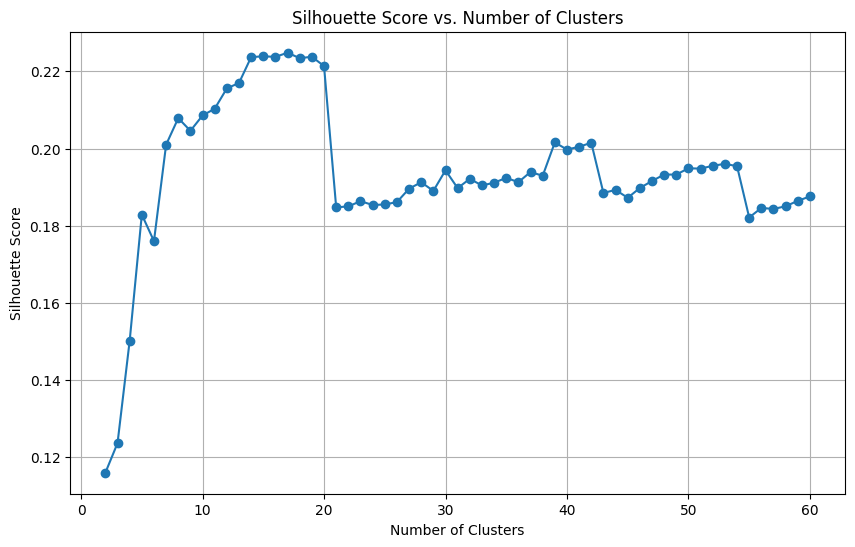

In [100]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'embeddings' is your dataset
embeddings_normalized = normalize(embeddings)

# Range of number of clusters
n_clusters = range(2, 61)  # Silhouette score cannot be computed with only one cluster

silhouette_scores = []

for k in n_clusters:
    kmeans = KMeans(n_clusters=k, n_init=1, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings_normalized)
    
    # Compute the silhouette score and append it to the list
    score = silhouette_score(embeddings_normalized, cluster_labels)
    silhouette_scores.append(score)
    print(f"Silhouette Score for k={k}: {score}")

# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

c:\Users\arash\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


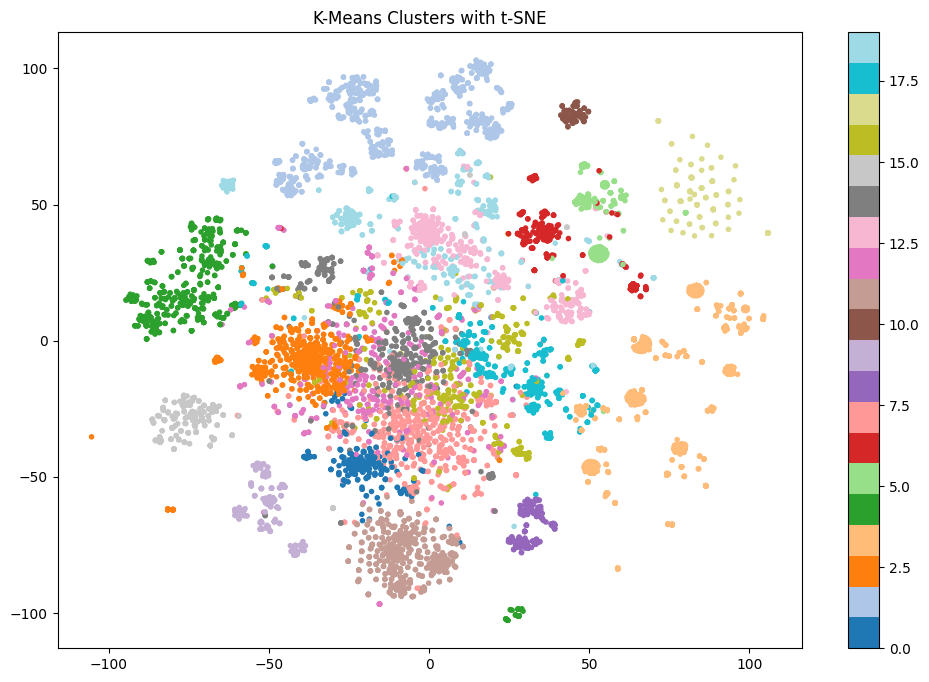

In [102]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming 'embeddings' is your dataset with text data represented in high-dimensional space

# Normalize the embeddings to unit length, which makes the KMeans clustering similar to using cosine similarity
embeddings_normalized = normalize(embeddings)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=20, random_state=42)  # You can choose a number of clusters suited for your dataset
kmeans.fit(embeddings_normalized)
labels = kmeans.labels_

# Reduce dimensions to 2D using t-SNE for visualization purposes
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_normalized)

# Plot the clusters
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap='tab20', marker='.')
plt.title('K-Means Clusters with t-SNE')
plt.colorbar()
plt.show()